In [390]:
import pandas as pd
from jiwer import wer
import string
import matplotlib.pyplot as plt

# Prepocessing

In [391]:
def sort_by_file_name(df):
    df[['part1', 'part2', 'part3']] = df['file_name'].str.split('-', expand=True)
    df['part1'] = df['part1'].astype(int)
    df['part2'] = df['part2'].astype(int)
    df['part3'] = df['part3'].astype(int)
    df = df.sort_values(by=['part1', 'part2', 'part3'])
    df = df.drop(columns=['part1', 'part2', 'part3'])
    df = df.reset_index(drop=True)
    return df

def preprocess_csv(csv_path, rm_stutter=False):
    df = pd.read_csv(csv_path, index_col=0)
    df['file_name'] = df['file_name'].str.replace('.flac', '', regex=False)
    df['file_name'] = df['file_name'].str.replace('.csv', '', regex=False)
    df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lstrip())
    if rm_stutter==True:
        df.iloc[:, 1] = df.iloc[:, 1].str.replace('stutter', '', case=False)
    df = sort_by_file_name(df)
    return df

In [392]:
df_librispeech_gt = preprocess_csv("librispeech_result/gt_librispeech.csv")
df_librispeech_gt.rename(columns={'ground_truth': 'librispeech_gt'}, inplace=True)

df_librispeech_whisper = preprocess_csv("librispeech_result/whisper_librispeech.csv")
df_librispeech_whisper.rename(columns={'prediction': 'librispeech_whisper'}, inplace=True)

df_librispeech_wav2vec = preprocess_csv("librispeech_result/wav2vec_librispeech.csv")
df_librispeech_wav2vec.rename(columns={'prediction': 'librispeech_wav2vec'}, inplace=True)

# df_libristutter_gt = preprocess_csv("libristutter_result/gt_libristutter.csv", rm_stutter=True)
# df_libristutter_gt.rename(columns={'gt_transcriptions': 'libristutter_gt'}, inplace=True)
# display(df_libristutter_gt.head())

df_libristutter_whisper = preprocess_csv("libristutter_result/whisper_libristutter.csv")
df_libristutter_whisper.rename(columns={'prediction': 'libristutter_whisper'}, inplace=True)
# display(df_libristutter_whisper.head())

df_libristutter_wav2vec = preprocess_csv("libristutter_result/wav2vec_libristutter.csv")
df_libristutter_wav2vec.rename(columns={'prediction': 'libristutter_wav2vec'}, inplace=True)

,file_name,libristutter_gt,total_stutter
0,78-368-0000,chapter 1 mrs rachel lynde is surprised mrs ...,11
1,78-368-0001,it had its source away back in the woods at th...,8
2,78-368-0002,for not even if brooke could run past mrs rach...,0
3,78-368-0003,and that if she noticed anything odd or out of...,6
4,78-368-0004,but mrs rachel lynde was one of those capable...,7


,file_name,libristutter_whisper
0,78-368-0000,chapter 23 it was eight oclock when we landed ...
1,78-368-0001,the wind which had fallen in the south now ros...
2,78-368-0002,the clouds swept across its swifter than the f...
3,78-368-0003,that were beginning to rise suddenly a heavy s...
4,78-368-0004,and not shrink from the conflict until my own ...


# Calculate WER

In [393]:
def calculate_wer(df_model, df_gt, output_filename):
    df_wer = pd.merge(df_model, df_gt, on='file_name')
    df_wer[output_filename] = df_wer.apply(lambda row: wer(row.iloc[1], row.iloc[2]), axis=1)
    df_wer.to_csv(f'wer_scores_csv/{output_filename}.csv', index=False)
    return df_wer

In [394]:
df_librispeech_whisper_wer = calculate_wer(df_librispeech_whisper, df_librispeech_gt, 'wer_librispeech_whisper')
df_librispeech_wav2vec_wer = calculate_wer(df_librispeech_wav2vec, df_librispeech_gt, 'wer_librispeech_wav2vec')

df_libristutter_whisper_wer = calculate_wer(df_libristutter_whisper, df_librispeech_gt, 'wer_libristutter_whisper')
df_libristutter_wav2vec_wer = calculate_wer(df_libristutter_wav2vec, df_librispeech_gt, 'wer_libristutter_wav2vec')

# Create the final csv file ‘wer_librispeech_libristutter.csv’

In [395]:
def merge_dfs(dfs):
    df_list = [df[['file_name', df.columns[-1]]] for df in dfs] # Extract file_name and WER from each df
    merged_df = df_list[0]
    for df in df_list[1:]:
        merged_df = merged_df.merge(df, on='file_name', how='inner')
    return merged_df

In [396]:
dfs = [
    df_librispeech_whisper_wer, df_librispeech_wav2vec_wer,
    df_libristutter_whisper_wer, df_libristutter_wav2vec_wer,
]
df_librispeech_libristutter = merge_dfs(dfs)
df_librispeech_libristutter.to_csv('wer_scores_csv/wer_librispeech_libristutter.csv', index=False)
df_librispeech_libristutter.iloc[1310:1315]

,file_name,wer_librispeech_whisper,wer_librispeech_wav2vec,wer_libristutter_whisper,wer_libristutter_wav2vec
1310,3699-19402-0027,0.047619,0.000000,0.047619,0.000000
1311,3699-19402-0028,0.156250,0.030303,0.235294,0.085714
1312,3699-19402-0029,0.050000,0.000000,0.291667,0.166667
1313,3699-19402-0030,0.074074,0.000000,0.218750,0.181818
1314,3699-47246-0000,21.500000,0.000000,21.500000,0.000000


# Result Analysis

In [397]:
print('Mean WER:')
print('LibriSpeech Whisper:', df_librispeech_libristutter['wer_librispeech_whisper'].mean())
print('LibriStutter Whisper:', df_librispeech_libristutter['wer_libristutter_whisper'].mean())
print('LibriSpeech Wav2vec:', df_librispeech_libristutter['wer_librispeech_wav2vec'].mean())
print('LibriStutter Wav2vec:', df_librispeech_libristutter['wer_libristutter_wav2vec'].mean())

Mean WER:
LibriSpeech Whisper: 0.07273705785933962
LibriStutter Whisper: 0.12003371741438162
LibriSpeech Wav2vec: 0.014706197643528126
LibriStutter Wav2vec: 0.09635759641553532


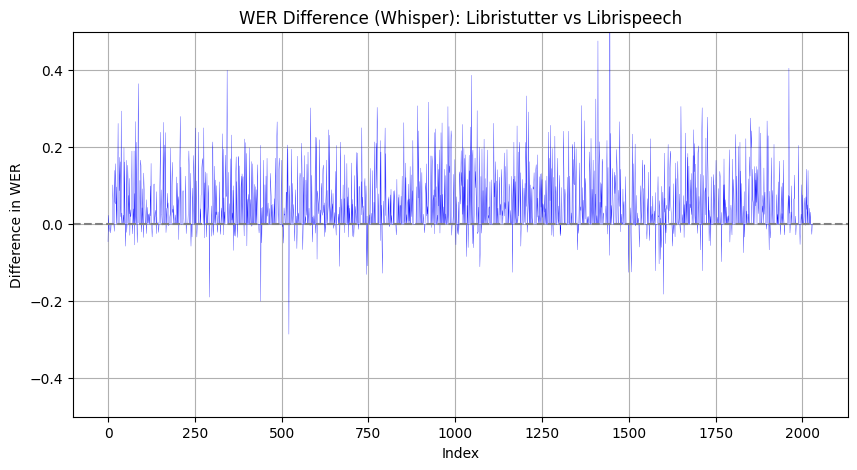

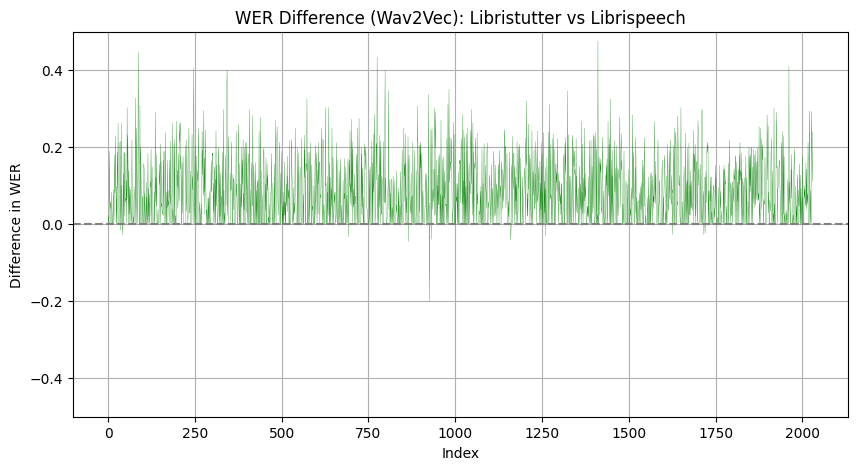

In [432]:
df_librispeech_libristutter['whisper_diff'] = df_librispeech_libristutter['wer_libristutter_whisper'] - df_librispeech_libristutter['wer_librispeech_whisper']
df_librispeech_libristutter['wav2vec_diff'] = df_librispeech_libristutter['wer_libristutter_wav2vec'] - df_librispeech_libristutter['wer_librispeech_wav2vec']

# Plot 1: Whisper WER Difference
plt.figure(figsize=(10, 5))
plt.plot(df_librispeech_libristutter.index, df_librispeech_libristutter['whisper_diff'], color='blue', linewidth=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Difference in WER')
plt.ylim(-.5, .5)
plt.title('WER Difference (Whisper): Libristutter vs Librispeech')
plt.grid(True)
plt.show()

# Plot 2: Wav2Vec WER Difference
plt.figure(figsize=(10, 5))
plt.plot(df_librispeech_libristutter.index, df_librispeech_libristutter['wav2vec_diff'], color='green', linewidth=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Difference in WER')
plt.ylim(-.5, .5)
plt.title('WER Difference (Wav2Vec): Libristutter vs Librispeech')
plt.grid(True)
plt.show()

In [433]:
df_librispeech_libristutter.describe()

,wer_librispeech_whisper,wer_librispeech_wav2vec,wer_libristutter_whisper,wer_libristutter_wav2vec,whisper_diff,wav2vec_diff
count,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000
mean,0.072737,0.014706,0.120034,0.096358,0.047297,0.081651
std,0.481030,0.030214,0.484820,0.086644,0.079897,0.083614
min,0.000000,0.000000,0.000000,0.000000,-0.285714,-0.200000
25%,0.000000,0.000000,0.034483,0.023256,0.000000,0.000000
50%,0.047247,0.000000,0.088889,0.080863,0.000000,0.061224
75%,0.088889,0.024390,0.166667,0.153846,0.084813,0.137255
max,21.500000,0.400000,21.500000,0.476190,1.114286,0.476190


# Post-Processing

In [400]:
import nltk
nltk.download('words')
from nltk.corpus import words
import numpy as np
import difflib
from rapidfuzz import process

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dlee3\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


### Repetition Removal

In [420]:
def remove_repeated_words(sentence):
    words = sentence.split()
    result = []
    for word in words:
        if len(result) == 0 or word != result[-1]:
            result.append(word)
    return ' '.join(result)

In [426]:
df_libristutter_whisper_wer['libristutter_whisper_rmrepeat'] = df_libristutter_whisper_wer['libristutter_whisper'].apply(remove_repeated_words)
df_libristutter_whisper_wer['wer_libristutter_whisper_rmrepeat'] = df_libristutter_whisper_wer.apply(lambda row: wer(row['libristutter_whisper_rmrepeat'], row['librispeech_gt']), axis=1)
df_libristutter_wav2vec_wer['libristutter_wav2vec_rmrepeat'] = df_libristutter_wav2vec_wer['libristutter_wav2vec'].apply(remove_repeated_words)
df_libristutter_wav2vec_wer['wer_libristutter_wav2vec_rmrepeat'] = df_libristutter_wav2vec_wer.apply(lambda row: wer(row['libristutter_wav2vec_rmrepeat'], row['librispeech_gt']), axis=1)

In [427]:
print('Mean WER:')
print('LibriSpeech Whisper:', df_librispeech_libristutter['wer_librispeech_whisper'].mean())
print('LibriStutter Whisper:', df_libristutter_whisper_wer['wer_libristutter_whisper'].mean())
print('LibriStutter Whisper Repeated Words Removed:', df_libristutter_whisper_wer['wer_libristutter_whisper_rmrepeat'].mean())
print('LibriSpeech Wav2vec:', df_librispeech_libristutter['wer_librispeech_wav2vec'].mean())
print('LibriStutter Wav2Vec:', df_libristutter_wav2vec_wer['wer_libristutter_wav2vec'].mean())
print('LibriStutter Wav2Vec Repeated Words Removed:', df_libristutter_wav2vec_wer['wer_libristutter_wav2vec_rmrepeat'].mean())

Mean WER:
LibriSpeech Whisper: 0.07273705785933962
LibriStutter Whisper: 0.13047447231551174
LibriStutter Whisper Repeated Words Removed: 0.12649042902366908
LibriSpeech Wav2vec: 0.014706197643528126
LibriStutter Wav2Vec: 0.09544720073332007
LibriStutter Wav2Vec Repeated Words Removed: 0.08673949107904634


### Gibberish Removal

In [404]:
valid_words = set(words.words()) # valid English words

# def get_closest_match(word, valid_words):
#     closest_matches = difflib.get_close_matches(word, valid_words, n=1)
#     return closest_matches[0] if closest_matches else word

def get_closest_match(word, valid_words, max_matches=1):
    matches = process.extract(word, valid_words, limit=max_matches) # rapidfuzz, faster than difflib
    return matches[0][0] if matches else word

def replace_gibberish(sentence):
    cleaned_sentence = []
    for word in sentence.split():
        if word.lower() in valid_words:
            cleaned_sentence.append(word)
        else:
            cleaned_sentence.append(get_closest_match(word.lower(), valid_words))
    return ' '.join(cleaned_sentence)

In [ ]:
df_libristutter_whisper_wer['libristutter_whisper_rmgibberish'] = df_libristutter_whisper_wer['libristutter_whisper'].apply(replace_gibberish)
df_libristutter_whisper_wer['wer_libristutter_whisper_rmgibberish'] = df_libristutter_whisper_wer.apply(lambda row: wer(row['libristutter_whisper_rmgibberish'], row['librispeech_gt']) if row.iloc[4] and row.iloc[2] else np.nan, axis=1)
df_libristutter_wav2vec_wer['libristutter_wav2vec_rmgibberish'] = df_libristutter_wav2vec_wer['libristutter_wav2vec'].apply(replace_gibberish)
df_libristutter_wav2vec_wer['wer_libristutter_wav2vec_rmgibberish'] = df_libristutter_wav2vec_wer.apply(lambda row: wer(row['libristutter_wav2vec_rmgibberish'], row['librispeech_gt']) if row.iloc[4] and row.iloc[2] else np.nan, axis=1)

In [429]:
print('Mean WER:')
print('LibriSpeech Whisper:', df_librispeech_libristutter['wer_librispeech_whisper'].mean())
print('LibriStutter Whisper:', df_libristutter_whisper_wer['wer_libristutter_whisper'].mean())
print('LibriStutter Whisper Gibberish Removed:', df_libristutter_whisper_wer['wer_libristutter_whisper_rmgibberish'].mean())
print('LibriSpeech Wav2vec:', df_librispeech_libristutter['wer_librispeech_wav2vec'].mean())
print('LibriStutter Wav2Vec:', df_libristutter_wav2vec_wer['wer_libristutter_wav2vec'].mean())
print('LibriStutter Wav2Vec Gibberish Removed:', df_libristutter_wav2vec_wer['wer_libristutter_wav2vec_rmgibberish'].mean())

Mean WER:
LibriSpeech Whisper: 0.07273705785933962
LibriStutter Whisper: 0.13047447231551174
LibriStutter Whisper Gibberish Removed: 0.21295997894215987
LibriSpeech Wav2vec: 0.014706197643528126
LibriStutter Wav2Vec: 0.09544720073332007
LibriStutter Wav2Vec Gibberish Removed: 0.1877242944024006


### Repeated Words and Gibberish Removal

In [430]:
df_libristutter_whisper_wer['libristutter_whisper_rmgibberishrepeat'] = df_libristutter_whisper_wer['libristutter_whisper_rmgibberish'].apply(remove_repeated_words)
df_libristutter_whisper_wer['wer_libristutter_whisper_rmgibberishrepeat'] = df_libristutter_whisper_wer.apply(lambda row: wer(row['libristutter_whisper_rmgibberishrepeat'], row['librispeech_gt']), axis=1)
df_libristutter_wav2vec_wer['libristutter_wav2vec_rmgibberishrepeat'] = df_libristutter_wav2vec_wer['libristutter_wav2vec_rmgibberish'].apply(remove_repeated_words)
df_libristutter_wav2vec_wer['wer_libristutter_wav2vec_rmgibberishrepeat'] = df_libristutter_wav2vec_wer.apply(lambda row: wer(row['libristutter_wav2vec_rmgibberishrepeat'], row['librispeech_gt']), axis=1)

In [431]:
print('Mean WER:')
print('LibriSpeech Whisper:', df_librispeech_libristutter['wer_librispeech_whisper'].mean())
print('LibriStutter Whisper:', df_libristutter_whisper_wer['wer_libristutter_whisper'].mean())
print('LibriStutter Whisper Repeated Words Removed:', df_libristutter_whisper_wer['wer_libristutter_whisper_rmrepeat'].mean())
print('LibriStutter Whisper Gibberish Removed:', df_libristutter_whisper_wer['wer_libristutter_whisper_rmgibberish'].mean())
print('LibriStutter Whisper Gibberish and Repeated Words Removed:', df_libristutter_whisper_wer['wer_libristutter_whisper_rmgibberishrepeat'].mean())
print('LibriSpeech Wav2vec:', df_librispeech_libristutter['wer_librispeech_wav2vec'].mean())
print('LibriStutter Wav2Vec:', df_libristutter_wav2vec_wer['wer_libristutter_wav2vec'].mean())
print('LibriStutter Wav2Vec Repeated Words Removed:', df_libristutter_wav2vec_wer['wer_libristutter_wav2vec_rmrepeat'].mean())
print('LibriStutter Wav2Vec Gibberish and Repeated Words Removed:', df_libristutter_wav2vec_wer['wer_libristutter_wav2vec_rmgibberishrepeat'].mean())


Mean WER:
LibriSpeech Whisper: 0.07273705785933962
LibriStutter Whisper: 0.13047447231551174
LibriStutter Whisper Repeated Words Removed: 0.12649042902366908
LibriStutter Whisper Gibberish Removed: 0.21295997894215987
LibriStutter Whisper Gibberish and Repeated Words Removed: 0.20950830767421064
LibriSpeech Wav2vec: 0.014706197643528126
LibriStutter Wav2Vec: 0.09544720073332007
LibriStutter Wav2Vec Repeated Words Removed: 0.08673949107904634
LibriStutter Wav2Vec Gibberish and Repeated Words Removed: 0.17961293477467494


# Manual Inspection

In [17]:
from jiwer import wer, cer

predicted_example = '然后我学的是历史的专业是。'
gt_with_bracket = '然后我学的是<工作单位>的专业是。'
gt_without_bracket = '然后我学的是的专业是。'

wer_with_bracket = cer(predicted_example, gt_with_bracket)
wer_without_bracket = cer(predicted_example, gt_without_bracket)

print(f'wer with bracket: {wer_with_bracket}')
print(f'wer without bracket: {wer_without_bracket}')

wer with bracket: 0.46153846153846156
wer without bracket: 0.15384615384615385


^ Better to remove bracket!